# ICA on Asymmetrical nonG Field
#### Working with Gaussian random field (GRF) + asymmetrical nonG field

<b>Import modules</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import matplotlib.gridspec as grd
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

<b>Set parameters and initialize GRFs</b>

In [2]:
# Parameters
logtwo_N = 20
N = 2**logtwo_N
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seedg = 50
seedf = 10000
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)
Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3

# Other NG parameters
alpha = 1.0
nu = 2
c, w = 2, .2

# Generate the grfs using gaussianfield
g = grf.gaussian_random_field_1D(N, BoxSize=N, seed=seed)
f = grf.gaussian_random_field_1D(N, BoxSize=N, seed=10000)

In [3]:
# fig, ax = plt.subplots(1,figsize=(14,8))

# ax.plot(g)
# ax.set_title(r'$\zeta_{G}$')
# ax.set(xlabel=r'$x$', ylabel="Amplitude")
# fig.tight_layout()
# print(np.mean(g))

In [4]:
# g_ft = np.fft.fft(g)
# g_ps = np.absolute(g_ft)**2

# freqs = np.fft.fftfreq(g.size)

# idx = np.argsort(freqs)

# # P, k = cf.angular_average(g_ps, np.arange(0, g_ps[idx].size), 100)

# plt.plot(freqs[idx], g_ps[idx]*freqs[idx])
# # plt.ylim(-10, 10000000)
# plt.show()

## Generate nonG fields

In [5]:
# Generate nonG fields

# Extract the standard deviation of the gaussian fields
s = g.std()
sf = f.std()

# Generate the non-gaussian components that will be added to the gaussian fields
# Note that 'g' is the field used to generate the NG components, so the NG
# is correlated with 'g', and 'f' is a different Gaussian random field with
# which the NG is uncorrelated
NG_symsinh = px.map_sinh(g, nu*s, alpha) - g
NG_asymsinh = px.map_asymm_sinh(g, nu*s, alpha) - g
NG_smooth_bump = px.map_smooth_bump(g, c, w) - g
NG_squared = g**2 - g

# Generate the correlated NG zeta fields 
zeta_NG_symsinh = g + NG_symsinh
zeta_NG_asymsinh = g + NG_asymsinh
zeta_NG_smooth_bump = g + NG_smooth_bump
zeta_NG_squared = g + g**2

# Generate the uncorrelated NG zeta fields 
zeta_NG_symsinh_uncorr = f + NG_symsinh
zeta_NG_asymsinh_uncorr = f + NG_asymsinh
zeta_NG_smooth_bump_uncorr = f + NG_smooth_bump
zeta_NG_squared_uncorr = f + g**2

# Test the asymmetric sinh function applied to a linear function tf
tf = np.linspace(-4, 4, N)
zeta_NG_asymsinh_test = px.map_asymm_sinh(tf, nu*s, alpha) - tf

# Generate gaussian distribution from mean and std of NG zeta fields
# ???

## Why are we getting an error for invalid value in power?

# Independent Component Analysis

$\texttt{sklearn}$ module contains contains a $\texttt{FastICA}$ capability. We can chose the cost function (measure of non-Gaussianity): $\texttt{cube}$ for kurtosis, and $\texttt{logcosh}$ for negentropy approximation.



In [6]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
import modules.colorednoise as cn

## Setup for two different linear combinations (mixed, observed signals) of same zeta(G) and zeta(NG) 

In [7]:
# Note that 'g' is the field used to generate the NG component called 'NG_asymsinh', 
# so 'NG_asymsinh' is correlated with 'g', and 'f' is a different Gaussian random 
# field with which the 'NG_asymsinh' is uncorrelated. 

source_g = f
source_ng = NG_asymsinh
size_field = source_g.size

source_components = np.vstack([source_g, source_ng])
num_comps = 2
num_samples = 2

mix_matrix = (1+np.random.random((num_samples,num_comps)))/2.0
mix_signal_pre = np.dot(mix_matrix, source_components)

In [8]:
correlated = False

## Preprocess the fields

In [9]:
"""
Handling the two observed signals separately. 
Preprocessing involves mean subtraction and dividing by the variance (in k-space).
"""

# Sample 1
sample1_pre = mix_signal_pre[0, :]
# m1 = np.mean(sample1_pre)
# sample1_ms = sample1_pre - m1 #Subtracting the mean

# sample1_ft = np.fft.fft(sample1_ms)
# sample1_sqrtpower = np.absolute(sample1_ft) #k-space variance

# sample1_ms_white_ft = sample1_ft / sample1_sqrtpower * (size_field**(1/2)) #Whitening the field

# sample1 = np.fft.ifft(sample1_ms_white_ft).real
sample1 = sample1_pre

# Sample 2 - same procedure as above
sample2_pre = mix_signal_pre[1, :]
# m2 = np.mean(sample2_pre)
# sample2_ms = sample2_pre - m2

# sample2_ft = np.fft.fft(sample2_ms)
# sample2_sqrtpower = np.absolute(sample2_ft)

# sample2_ms_white_ft = sample2_ft / sample2_sqrtpower * (size_field**(1/2))

# sample2 = np.fft.ifft(sample2_ms_white_ft).real
sample2 = sample2_pre

# Gaussian - same procedure as above
mg = np.mean(source_g)
gauss_ms = source_g - mg

gauss_ft = np.fft.fft(gauss_ms)
gauss_sqrtpower = np.absolute(gauss_ft)

gauss_ms_white_ft = gauss_ft / gauss_sqrtpower * (size_field**(1/2))

gauss_white = np.fft.ifft(gauss_ms_white_ft).real

# Mix the samples back again
mix_signal = np.vstack([sample1, sample2])

# plt.figure(figsize=(18,5))
# plt.plot(sample1)

# plt.figure(figsize=(18,5))
# plt.plot(sample2)

## Plot the sources

Text(0, 0.5, 'Amplitude')

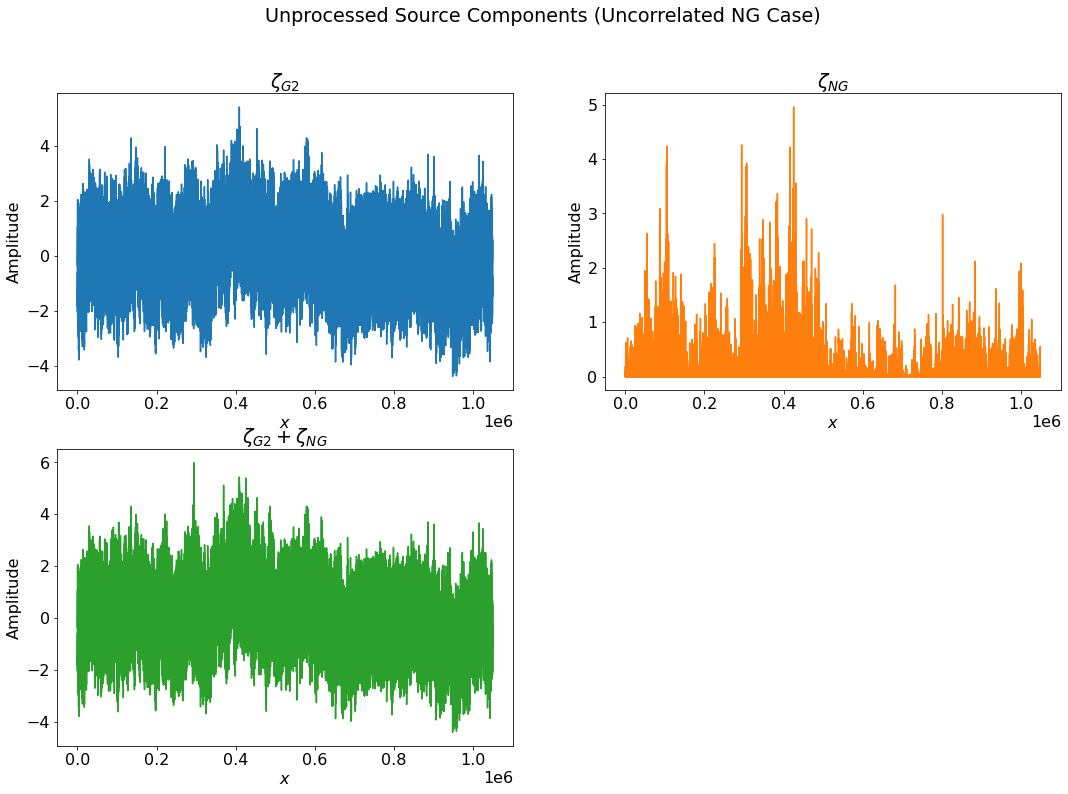

In [10]:
"""
Unprocessed source components
"""

if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'
    
plt.figure(figsize=(18,12))
plt.suptitle(r'Unprocessed Source Components ({0} NG Case)'.format(t))

plt.subplot(221)
plt.plot(source_g)
plt.title(r'$\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(source_ng, color='C1')
plt.title(r'$\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(223)
plt.plot(source_ng + source_g, color='C2')
plt.title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

Text(0.94, 0.28, '$\\zeta_{G2}+\\zeta_{NG_1}$')

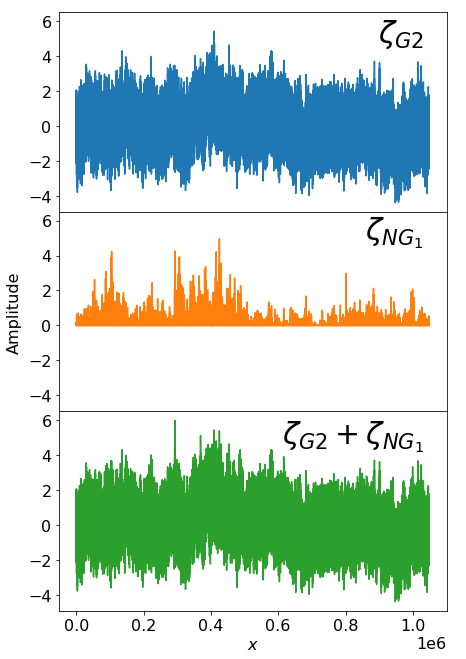

In [13]:
"""
Same plots as above
"""

if correlated:
    k = 'G1'
    t = 'Correlated'
else:
    k = 'G2'
    t = 'Uncorrelated'

# ax1.plot(source_g)
# ax1.set_title(r'$\zeta_{{{0}}}$'.format(k))

# ax2.plot(source_ng, color='C1')
# ax2.set_title(r'$\zeta_{NG}$')

# ax3.plot(source_ng + source_g, color='C2')
# ax3.set_title(r'$\zeta_{{{0}}}+\zeta_{{NG}}$'.format(k))

fig, ax = plt.subplots(3, 1,  sharex=True, sharey=True, figsize=(7,10))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# Original NG component
ax[0].plot(source_g)
ax[1].plot(source_ng, color='C1')
ax[2].plot(source_ng + source_g, color='C2')
ax[2].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.94, 0.95, r'$\zeta_{{{0}}}$'.format(k), fontsize=30, horizontalalignment='right')
plt.text(0.94, 0.62, r'$\zeta_{NG_1}$', fontsize=30, horizontalalignment='right')
plt.text(0.94, 0.28, r'$\zeta_{{{0}}}+\zeta_{{NG_1}}$'.format(k), fontsize=30, horizontalalignment='right')

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

## Plot the inputs

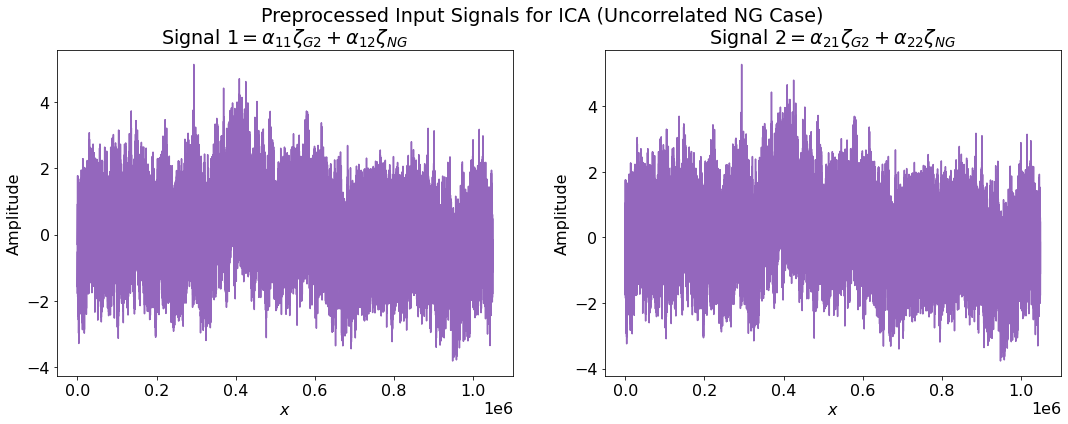

In [12]:
plt.figure(figsize=(18,6))
plt.suptitle(r'Preprocessed Input Signals for ICA ({0} NG Case)'.format(t))

plt.subplot(121)
plt.plot(sample1, color='C4')
plt.title(r'Signal 1$= \alpha_{{11}} \zeta_{{{0}}} + \alpha_{{12}} \zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(sample2, color='C4')
plt.title(r'Signal 2$=\alpha_{{21}} \zeta_{{{0}}} + \alpha_{{22}} \zeta_{{NG}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

fig.tight_layout()

# if correlated:
#     plt.savefig('ICA_corr_mix.png')
# else:
#     plt.savefig('ICA_uncorr_mix.png')

## Apply $\texttt{FastICA}$

In [14]:
ica = FastICA(n_components=num_comps, algorithm='parallel', max_iter=10000, tol=1e-4, whiten='unit-variance', fun='logcosh')
sl = ica.fit_transform(mix_signal.T)

In [15]:
print(ica.get_params())

{'algorithm': 'parallel', 'fun': 'logcosh', 'fun_args': None, 'max_iter': 10000, 'n_components': 2, 'random_state': None, 'tol': 0.0001, 'w_init': None, 'whiten': 'unit-variance'}


In [16]:
# Extract the individual components

negen_m1 = np.mean(sl[:, 0])
negen_m2 = np.mean(sl[:, 1])
negen_comp1 = -sl[:, 0]
negen_comp2 = sl[:, 1]

## Plot extracted signals

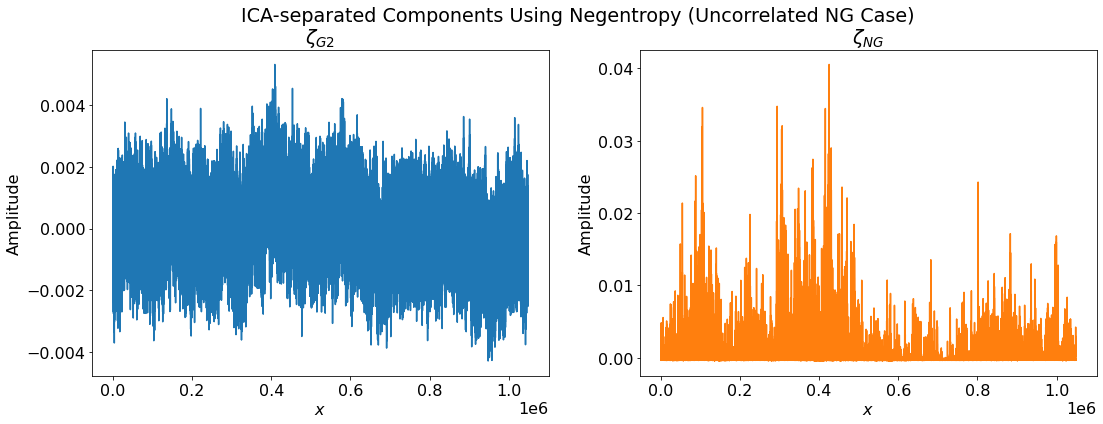

In [17]:
# Negentropy plots

plt.figure(figsize=(18,6))
plt.suptitle('ICA-separated Components Using Negentropy ({0} NG Case)'.format(t))

plt.subplot(121)
plt.plot(negen_comp2)
plt.title(r'$\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(122)
plt.plot(negen_comp1, color='C1')
plt.title(r'$\zeta_{NG}$')
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

fig.tight_layout()
# if correlated:
#     plt.savefig('ICA_corr_negentropy.png')
# else:
#     plt.savefig('ICA_uncorr_negentropy.png')

In [ ]:
"""
Gaussian component plots
"""

plt.figure(figsize=(14,10))
plt.suptitle(r'Source $\zeta_{{{0}}}$ vs. ICA-separated $\zeta_{{{0}}}$ (Uncorrelated NG Case)'.format(k))

# Original Gaussian component
plt.subplot(211)
plt.plot(source_g)
plt.title(r'Source $\zeta_{{{0}}}$'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

plt.subplot(212)
plt.plot(negen_comp2)
plt.title(r'ICA-separated $\zeta_{{{0}}}$ Using Negentropy'.format(k))
plt.xlabel(r'$x$')
plt.ylabel("Amplitude")

fig.tight_layout()

In [ ]:
"""
Non-Gaussian component plots
"""

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(14,14))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

# Original NG component
ax[0].plot(source_ng, color='C1')
ax[1].plot(-250*negen_comp1, color='C1')
ax[1].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.9, 0.9, r'Source $\zeta_{NG_1}$', fontsize=30, horizontalalignment='right')
plt.text(0.9, 0.4, r'Extracted $\zeta_{NG_1}$', fontsize=30, horizontalalignment='right')

## Plot scatter of source and extracted NG 

In [ ]:
plt.figure(figsize=(11,10))

# plt.subplot(211)
# plt.axhline(color='black', ls='--', linewidth=1)
# plt.scatter(source_ng, kurt_comp1, color='C1')
# plt.title(r'Kurtosis-extracted $\zeta_{NG}$ vs Source $\zeta_{NG}$')
# plt.xlabel(r'Source $\zeta_{NG}$')
# plt.ylabel(r'Extracted $\zeta_{NG}$')
# plt.ylim(-0.01, 0.02) 


plt.subplot(211)
plt.axhline(color='black', ls='--', linewidth=1)
plt.scatter(source_ng, negen_comp1, color='C2')
plt.title(r'ICA-separated $\zeta_{{NG}}$ vs Source $\zeta_{{NG}}$ Using Negentropy ({0} NG Case)'.format(t))
plt.xlabel(r'Source $\zeta_{NG}$')
plt.ylabel(r'Extracted $\zeta_{NG}$')
# plt.ylim(-0.01, 0.02) 

# if correlated:
#     plt.savefig('ICA_corr_scatter.png')
# else:
#     plt.savefig('ICA_uncorr_scatter.png')

In [ ]:
source_ng_new = source_ng / source_ng.std()
negen_new = negen_comp1 / negen_comp1.std()

# source_ng_new = source_ng_new - source_ng_new.mean()
# negen_new = negen_new - negen_new.mean()

fig, ax = plt.subplots(1,figsize=(14,14))

ax.axhline(color='black', ls='--', linewidth=1)
ax.scatter(source_ng_new, negen_new, color='C2')
ax.set(xlabel=r'Source $\zeta_{NG_1}$', ylabel=r'Extracted $\zeta_{NG_1}$')
fig.tight_layout()